<a href="https://colab.research.google.com/github/EASC/tvdi_hpc/blob/main/tp_final_fonnegra_solarte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/cursos/HPC/tp_final/code

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/cursos/HPC/tp_final/code'
/content/gdrive/MyDrive/cursos/HPC/tp_final/code


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from osgeo import gdal
from gdalconst import *
from scipy import stats
import sys
import os

def main_tvdi(img_ndvi, img_lst, salida_tvdi):
    #cargar imágenes
    ds_ndvi = gdal.Open(img_ndvi)
    sds_ndvi = ds_ndvi.GetRasterBand(1)
    matriz_ndvi = sds_ndvi.ReadAsArray()
    matriz_ndvi[matriz_ndvi==sds_ndvi.GetNoDataValue()]=np.nan

    ds_lst = gdal.Open(img_lst)
    sds_lst = ds_lst.GetRasterBand(1)
    matriz_lst = sds_lst.ReadAsArray()
    matriz_lst[matriz_lst==sds_lst.GetNoDataValue()]=np.nan
    matriz_lst[matriz_lst<=0]=np.nan

    ################################
    filas = matriz_lst.shape[0]
    cols = matriz_lst.shape[1]
    matriz_tvdi = np.zeros((filas,cols))
    ancho_filas = 2000

    #Parámetros
    min_ndvi = 0. #límite inferior de corte del histograma para calcular la línea de lst
    cant_px = 1 #Cantidad de píxeles a tomar de cada delta (10%)
    max_ndvi = np.nanmax(matriz_ndvi)
    delta = 0.01

    for i in range(0,filas-ancho_filas,1):
        matriz_ndvi_sub = matriz_ndvi[i:i+ancho_filas,:]
        matriz_lst_sub = matriz_lst[i:i+ancho_filas,:]
        
        #Eliminar valores nulos
        nan_data = ~np.isnan(matriz_lst_sub)
        nan_data2 = ~np.isnan(matriz_ndvi_sub)
        nan_data = nan_data*nan_data2
        lst_C_reshape = matriz_lst_sub[nan_data]
        ndvi_reshape = matriz_ndvi_sub[nan_data]

        lst_regr = []	#Lista para almacenar los valores de temperatura para la regresión
        ndvi_regr = []	#Lista para almacenar los valores de temperatura para la vegetación
        tmin = []
        if i%500==0:
            print("fila %s a %s: calculando deltas"%(str(i),str(i+ancho_filas)))
        
        for v in np.arange(min_ndvi,max_ndvi,delta):
            #Valores que están en el delta definido
            lst_arr = lst_C_reshape[np.where((ndvi_reshape>v) & (ndvi_reshape<=(v+delta)))]
            ndvi_arr = ndvi_reshape[np.where((ndvi_reshape>v) & (ndvi_reshape<=(v+delta)))]
            
            #Ordenar los valores según mayor temperatura
            indices = lst_arr.argsort()
            lst_arr = lst_arr[indices]
            ndvi_arr = ndvi_arr[indices]
            
            if len(ndvi_arr)>0:
                
                tmin.append(lst_arr[0]) #Valores bajos de la dispersión (límite húmedo)
                lst_regr.append(lst_arr[-cant_px:][0]) #Valores altos de la dispersión (límite seco)
                ndvi_regr.append(ndvi_arr[-cant_px:][0]) #Valor equivalente NDVI (límite seco)
            else:
                pass
        
        tmin = np.array(tmin)
        lst_regr = np.array(lst_regr)
        ndvi_regr = np.array(ndvi_regr)
        #Regresión lineal
        slope, intercept, r_value, p_value, std_err = stats.linregress(ndvi_regr,lst_regr)
        
        #Cálculo del TVDI
        tvdi = (matriz_lst_sub-np.mean(tmin))/(intercept+slope*matriz_ndvi_sub-np.mean(tmin))
        if i==0:
            matriz_tvdi[i:i+ancho_filas,:] = tvdi
        else:
            matriz_tvdi[i+ancho_filas//2:i+ancho_filas,:] = tvdi[ancho_filas//2:ancho_filas,:]
    #Salida de la imagen georreferenciada
    geoTs = ds_lst.GetGeoTransform() #Parámetros de la imagen (coordenadas origen y dimensiones)
    driver = gdal.GetDriverByName("GTiff") #Tipo de imagen (geotiff)
    prj = ds_lst.GetProjection() #Sistema de referencia de la imagen
    print("creando imagen")
    #Crear el espacio
    export=driver.Create(salida_tvdi,matriz_tvdi.shape[1],matriz_tvdi.shape[0],1,GDT_Float32)
    banda=export.GetRasterBand(1) #Cargo la banda creada en el paso anterior
    banda.WriteArray(matriz_tvdi) #Escribe los valores de NDVI en la imagen
    export.SetGeoTransform(geoTs) #Asigna los parametros de la transformacion a la salida
    export.SetProjection(prj) #define la proyección
    banda.FlushCache()#descargar de la memoria virtual al disco
    export.FlushCache()#descargar de la memoria virtual al disco



In [5]:
from time import time
a = time()
ndvi_fn = '../data/input/ndvi_2022209_500m.tif'
lst_fn = '../data/input/lst_Celsius_2022209_500m.tif'
output_tvdi = '../data/output/tvdi_2022209_500m.tif'
# main_tvdi(ndvi_fn, lst_fn, output_tvdi)
# b = time()
# print(f'Ejecución finalizada en {b - a} segundos')

In [6]:
def getBounds(ds):
    width, height = ds.RasterXSize, ds.RasterYSize
    xmin, ps_x, _, ymax, _, ps_y = ds.GetGeoTransform()
    xmax = xmin + width * ps_x
    ymin = ymax + height * ps_y

    return xmin, ymin, xmax, ymax

In [7]:
import matplotlib.pyplot as plt
ds = gdal.Open(ndvi_fn)
geoTs = ds.GetGeoTransform()


In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from osgeo import gdal
from gdalconst import *
from scipy import stats
import sys
import os

def load_img(filename):

    ds = gdal.Open(filename, gdal.GA_ReadOnly)
    sds = ds.GetRasterBand(1)
    nodata = sds.GetNoDataValue()
    sds_array = sds.ReadAsArray()
    sds_array[sds_array==nodata] = np.nan
    sds_array = sds_array[:2010, :]
    rows, cols = sds_array.shape

    dict_data = {'array': sds_array,
                 'geoTs': ds.GetGeoTransform(),
                 'proj': ds.GetProjection(),
                 'rows': rows,
                 'cols': cols
                 }

    return dict_data

def save_img(fname, array, rows, cols, geoTs, proj, bands=1, dtype=GDT_Float32):
    #Salida de la imagen georreferenciada
    driver = gdal.GetDriverByName("GTiff") #Tipo de imagen (geotiff)
    print("creando imagen")
    #Crear el espacio
    export = driver.Create(fname, cols, rows, bands, dtype)
    banda = export.GetRasterBand(1) #Cargar la banda creada en el paso anterior
    banda.WriteArray(array) #Escribir array en la imagen
    export.SetGeoTransform(geoTs) #Asignar los parametros de transformacion
    export.SetProjection(proj) #Definir la proyección
    banda.FlushCache() #Descargar de la memoria virtual al disco
    export.FlushCache() #Descargar de la memoria virtual al disco

def extract_dry_limit(ndvi, lst, vmin, vmax, px):
    #Valores que están en el delta definido
    vals = np.where((ndvi > vmin) & (ndvi <= vmax))
    lst_arr = lst[vals]
    ndvi_arr = ndvi[vals]
        
    #Ordenar los valores según mayor temperatura
    indices = lst_arr.argsort()
    lst_arr = lst_arr[indices]
    ndvi_arr = ndvi_arr[indices]
    tmin, lst_max, ndvi_max = None, None, None

    if len(ndvi_arr)>0:
        tmin = lst_arr[0] #Valores bajos de la dispersión (límite húmedo)
        lst_max = lst_arr[-px:][0] #Valores altos de la dispersión (límite seco)
        ndvi_max = ndvi_arr[-px:][0] #Valor equivalente NDVI (límite seco)
    
    return tmin, lst_max, ndvi_max


def calc_tvdi(ndvi, lst, min_ndvi, max_ndvi, delta, px):
    #Eliminar valores nulos
    nan_data = ~np.isnan(lst)
    nan_data2 = ~np.isnan(ndvi)
    nan_data = nan_data*nan_data2
    lst_C_reshape = lst[nan_data]
    ndvi_reshape = ndvi[nan_data]
    #Listas para almacenar los valores de lst y ndvi para la regresión
    lst_regr = []
    ndvi_regr = []
    tmin = []
    
    for v in np.arange(min_ndvi, max_ndvi, delta):
        dry_limit = extract_dry_limit(ndvi_reshape, lst_C_reshape, v, v+delta, px)
        
        if all(dry_limit):
            tmin.append(dry_limit[0])
            lst_regr.append(dry_limit[1])
            ndvi_regr.append(dry_limit[2])
    
    tmin = np.array(tmin)
    lst_regr = np.array(lst_regr)
    ndvi_regr = np.array(ndvi_regr)
    #Regresión lineal
    slope, intercept, r_val, p_val, std_err = stats.linregress(ndvi_regr, lst_regr)
        
    #Cálculo del TVDI
    tvdi = (lst - np.mean(tmin)) / (intercept + slope*ndvi - np.mean(tmin))
    return tvdi

def main_tvdi(im_ndvi, im_lst, im_tvdi, w_height=2000, min_ndvi=0, px=1, delta=0.01):
    '''
    im_ndvi: nombre y ruta de imagen de entrada de NDVI
    im_lst: nombre y ruta de imagen de entrada de LST
    im_tvdi: nombre y ruta de salida de imagen TVDI
    w_height: alto de ventana para cálculo del índice
    min_ndvi: límite inferior de corte del histograma para calcular límite seco
    px: cantidad de pixeles de LST a tener en cuenta (límite seco)
    delta: define el paso durante la iteración
    '''
    #cargar imágenes
    ndvi = load_img(im_ndvi)
    lst = load_img(im_lst)
    lst['array'][lst['array']<=0] = np.nan

    ################################
    array_tvdi = np.empty_like(ndvi['array'])
    
    #Parámetros
    max_ndvi = np.nanmax(ndvi['array'])
    
    for i in range(0, ndvi['rows']-w_height+1):

        if i%500==0:
            print(f'fila {i} a {i + w_height}: calculando deltas')

        ndvi_sub = ndvi['array'][i:i+w_height, :]
        lst_sub = lst['array'][i:i+w_height, :]
        tvdi_sub = calc_tvdi(ndvi_sub, lst_sub, min_ndvi, max_ndvi, delta, px)
        idx = w_height//2

        if i==0:
            array_tvdi[:idx+1, :] = tvdi_sub[:idx+1, :]
        elif i+w_height==ndvi['rows']:
            array_tvdi[i+idx:, :] = tvdi_sub[idx:, :]
        else:
            array_tvdi[i+idx, :] = tvdi_sub[idx, :]

    save_img(im_tvdi, array_tvdi, ndvi['rows'], ndvi['cols'], ndvi['geoTs'], ndvi['proj'])

In [22]:
if __name__ == '__main__':
    a = time()
    
    ndvi_fn = '../data/input/ndvi_2022209_500m.tif'
    lst_fn = '../data/input/lst_Celsius_2022209_500m.tif'
    output_tvdi = '../data/output/tvdi_2022209_500m_fn2.tif'
    main_tvdi(ndvi_fn, lst_fn, output_tvdi)
    b = time()
    print(f'Ejecución finalizada en {b - a} segundos')

fila 0 a 2000: calculando deltas
creando imagen
Ejecución finalizada en 15.377901792526245 segundos


In [53]:
from time import time, sleep
import multiprocessing as mp
import threading as thr


def calc_tvdi(q, ndvi, lst, min_ndvi, max_ndvi, delta, px, lock):
    #Listas para almacenar los valores de lst y ndvi para la regresión
    lst_regr = []
    ndvi_regr = []
    tmin = []

    #Eliminar valores nulos
    lock.acquire()
    nan_data = ~np.isnan(lst)
    nan_data2 = ~np.isnan(ndvi)
    nan_data = nan_data*nan_data2

    lst_C_reshape = lst[nan_data]
    ndvi_reshape = ndvi[nan_data]
    
    for v in np.arange(min_ndvi, max_ndvi, delta):
        dry_limit = extract_dry_limit(ndvi_reshape, lst_C_reshape, v, v+delta, px)
        
        if all(dry_limit):
            tmin.append(dry_limit[0])
            lst_regr.append(dry_limit[1])
            ndvi_regr.append(dry_limit[2])
    
    tmin = np.array(tmin)
    lst_regr = np.array(lst_regr)
    ndvi_regr = np.array(ndvi_regr)
    #Regresión lineal
    slope, intercept, r_val, p_val, std_err = stats.linregress(ndvi_regr, lst_regr)

    #Cálculo del TVDI
    tvdi = (lst - np.mean(tmin)) / (intercept + slope*ndvi - np.mean(tmin))
    lock.release()

    q.put(tvdi)
    
def main_tvdi(im_ndvi, im_lst, im_tvdi, lock, w_height=2000, min_ndvi=0, px=1, delta=0.01): # Cambio
    '''
    im_ndvi: nombre y ruta de imagen de entrada de NDVI
    im_lst: nombre y ruta de imagen de entrada de LST
    im_tvdi: nombre y ruta de salida de imagen TVDI
    w_height: alto de ventana para cálculo del índice
    min_ndvi: límite inferior de corte del histograma para calcular límite seco
    px: cantidad de pixeles de LST a tener en cuenta (límite seco)
    delta: define el paso durante la iteración
    '''
    q = mp.Queue()

    #cargar imágenes
    ndvi = load_img(im_ndvi)
    lst = load_img(im_lst)
    lst['array'][lst['array']<=0] = np.nan

    ################################
    array_tvdi = np.empty_like(ndvi['array'])
    
    #Parámetros
    max_ndvi = np.nanmax(ndvi['array'])
    process = list()
    for i in range(0, ndvi['rows']-w_height+1):
        if i%500==0:
            print(f'fila {i} a {i + w_height}: calculando deltas')
        ndvi_sub = ndvi['array'][i:i+w_height, :]
        lst_sub = lst['array'][i:i+w_height, :]
        t = thr.Thread(target=calc_tvdi, args=(q, ndvi_sub, lst_sub, min_ndvi, max_ndvi, delta, px, lock, ))
        t.start()
        process.append(t)

    for i in range(len(process)):

        # lock.acquire() # Cambio
        tvdi_sub = q.get()

        idx = w_height//2

        if i==0:
            array_tvdi[:idx+1, :] = tvdi_sub[:idx+1, :]
        elif i+w_height==ndvi['rows']:
            array_tvdi[i+idx:, :] = tvdi_sub[idx:, :]
        else:
            array_tvdi[i+idx, :] = tvdi_sub[idx, :]

        # lock.release() # Cambio
        
    for t in process: 
        t.join()

###########################################

    save_img(im_tvdi, array_tvdi, ndvi['rows'], ndvi['cols'], ndvi['geoTs'], ndvi['proj'])

if __name__ == '__main__':
    a = time()
    P = mp.cpu_count()

    manager = mp.Manager()         # Cambio
    lock = manager.Lock()

    ndvi_fn = '../data/input/ndvi_2022209_500m.tif'
    lst_fn = '../data/input/lst_Celsius_2022209_500m.tif'
    output_tvdi = '../data/output/tvdi_2022209_500m_fn_op_2.tif'
    main_tvdi(ndvi_fn, lst_fn, output_tvdi, lock)
    b = time()
    print(f'Ejecución finalizada en {b - a} segundos')

fila 0 a 2000: calculando deltas
creando imagen
Ejecución finalizada en 20.084842443466187 segundos


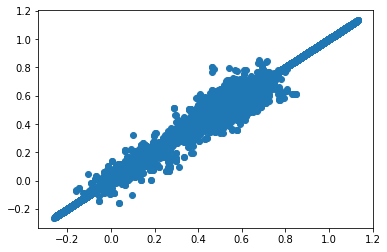

In [54]:
import matplotlib.pyplot as plt

im1 = gdal.Open('../data/output/tvdi_2022209_500m_fn.tif')
im2 = gdal.Open(output_tvdi)
sds1 = im1.ReadAsArray().flatten()
sds2 = im2.ReadAsArray().flatten()
plt.scatter(sds1, sds2)
plt.show()

In [78]:
import multiprocessing as mp
import threading as thr
import numpy as np

def suma(q, a, b):
    res = a+b
    q.put(res)

if __name__ == '__main__':
    ndvi = np.arange(10)
    lst = np.arange(10,20)

    tvdi = np.empty_like(ndvi)
    lista_t = list()
    for i in range(10):
        t = thr.Thread(target=suma, args=(q, ndvi[i], lst[i]))
        t.start()
        lista_t.append(t)
    
    for i in range(10):
        r = q.get()
        tvdi[i] = r
    
    for t in lista_t:
        t.join()
    
    for i in range(10):
        print(ndvi[i], lst[i], tvdi[i])


0 10 10
1 11 12
2 12 14
3 13 16
4 14 18
5 15 20
6 16 22
7 17 24
8 18 26
9 19 28
